In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jun  1 17:45:41 2020

@author: mahyarfazlyab
"""

# import sys
# sys.path.append("../Python/")

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.io import loadmat
import scipy.io
import os
import pickle


def export2matlab(file_name, net, A, B, save_model=False):
    '''
    Export pytorch fully connected network to matlab

    '''

    num_layers = int((len(net) - 1) / 2)
    dim_in = float(net[0].weight.shape[1])
    dim_out = float(net[-1].weight.shape[0])
    hidden_dims = [float(net[2 * i].weight.shape[0]) for i in range(0, num_layers)]

    # network dimensions
    dims = [dim_in] + hidden_dims + [dim_out]

    # get weights
    # weights = np.zeros((num_layers+1,))
    weights = [net[2 * i].weight.detach().numpy().astype(np.float64) for i in range(0, num_layers + 1)]

    # get biases
    # biases = np.zeros((num_layers+1,))
    biases = [net[2 * i].bias.detach().numpy().astype(np.float64).reshape(-1, 1) for i in range(0, num_layers + 1)]

    activation = str(net[1])[0:-2].lower()

    # export network data to matlab
    data = {}
    data['net'] = {'weights': weights, 'biases': biases, 'dims': dims, 'activation': activation, 'name': file_name}
    data['AMatrix'] = A
    data['BMatrix'] = B

    scipy.io.savemat(file_name + '.mat', data)





In [11]:
def main():

    with open('xs.pkl', 'rb') as f:
        Xtrain = pickle.load(f)

    with open('us.pkl', 'rb') as f:
        Ytrain = pickle.load(f)

    # data = loadmat("quadRotorTrainData.mat")
    # Xtrain = data['Xtrain']
    # Ytrain = data['Ytrain']
    # A = data['A']
    # B = data['B']

    A = np.zeros((6, 6))
    A[0, 3] = 1
    A[1, 4] = 1
    A[2, 5] = 1

    B = np.zeros((6, 3))
    B[3, 0] =  9.8
    B[4, 1] = -9.8
    B[5, 2] =  1

    A = np.eye(6) + A * 0.1
    B = B * 0.1
    print(A)
    print(B)
    print(Xtrain.shape)
    print(Ytrain.shape)
    trainset = torch.utils.data.TensorDataset(torch.Tensor(Xtrain), torch.Tensor(Ytrain))

    net = nn.Sequential(
        nn.Linear(6, 32),
        nn.ReLU(),
        nn.Linear(32, 32),
        nn.ReLU(),
        nn.Linear(32, 3))

    train_batch_size = 128
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size, shuffle=True,
                                              num_workers=2)
    epoch = 2000
    net.train()
    losses = []
    criterion = nn.MSELoss(size_average=None, reduce=None, reduction='mean')
    optimizer = optim.Adam(net.parameters(), lr=1e-3)
    for t in range(epoch):
        for i, (X, Y) in enumerate(trainloader):
            out = net(X)
            loss = criterion(out, Y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        losses.append(loss.item())
        if (np.mod(t, 10) == 0):
            print('epoch: ', t, 'MSE loss: ', loss.item())

    export2matlab('quadRotor' , net, A, B, save_model=True)

    return losses

[[1.  0.  0.  0.1 0.  0. ]
 [0.  1.  0.  0.  0.1 0. ]
 [0.  0.  1.  0.  0.  0.1]
 [0.  0.  0.  1.  0.  0. ]
 [0.  0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.  0.  1. ]]
[[ 0.    0.    0.  ]
 [ 0.    0.    0.  ]
 [ 0.    0.    0.  ]
 [ 0.98  0.    0.  ]
 [ 0.   -0.98  0.  ]
 [ 0.    0.    0.1 ]]
(4961, 6)
(4961, 3)
epoch:  0 MSE loss:  0.062010474503040314
epoch:  10 MSE loss:  0.011202693916857243
epoch:  20 MSE loss:  0.00807721633464098
epoch:  30 MSE loss:  0.005317296367138624
epoch:  40 MSE loss:  0.003956475295126438
epoch:  50 MSE loss:  0.004558625165373087
epoch:  60 MSE loss:  0.0037152012810111046
epoch:  70 MSE loss:  0.0034782919101417065
epoch:  80 MSE loss:  0.0024149331729859114
epoch:  90 MSE loss:  0.0022053178399801254
epoch:  100 MSE loss:  0.0026356433518230915
epoch:  110 MSE loss:  0.0018915917025879025
epoch:  120 MSE loss:  0.00231808889657259
epoch:  130 MSE loss:  0.00302883330732584
epoch:  140 MSE loss:  0.002061219187453389
epoch:  150 MSE loss:  0.0026258060242

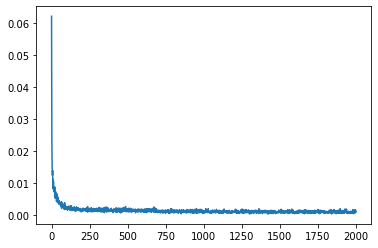

In [12]:

if __name__ == '__main__':
    losses = main()
    plt.plot(losses)


In [7]:
import matplotlib.pyplot as plt


NameError: name 'losses' is not defined